In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm

from itertools import permutations
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts import TimeSeries
from darts.models import NLinearModel
from darts.metrics import mape, mae, rmse


## Functions

In [2]:
## read data
def get_timeseries (filepath):
    electricity_consumption = pd.read_csv(filepath)
    # Convert dataframe to Timeseries
    ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )
    return ts



In [3]:
def eval_model(model, full_data,val_target, DESC, past_cov):
    pred_series = model.predict(n=42, past_covariates = full_data[past_cov])[DESC]
    plt.figure(figsize=(8, 5))
    full_data[DESC].plot(label="actual")
    pred_series[DESC].plot(label="forecast")
    plt.title("Seasonal Naive Bayes Model: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target, pred_series), mae(val_target, pred_series), mape(val_target, pred_series)))
    plt.legend()
    return pred_series

In [4]:
def eval_model_no_cov(model, full_data,val_target, DESC):
    pred_series = model.predict(n=42)[DESC]
    plt.figure(figsize=(8, 5))
    full_data[DESC].plot(label="actual")
    pred_series[DESC].plot(label="forecast")
    plt.title("Seasonal Naive Bayes Model: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target, pred_series), mae(val_target, pred_series), mape(val_target, pred_series)))
    plt.legend()
    return pred_series

In [5]:
def Nlinear_tuning(series, DESC, past_covariates=None, param_grid=None):

    train_data, val_target = series.split_after(pd.Timestamp('2021-01-01'))

    model = NLinearModel(
        input_chunk_length=1,
        output_chunk_length=1,
        n_epochs=1)

    if past_covariates is None:
        model.fit(train_data[DESC])
        best_model = model.gridsearch(param_grid, 
                    train_data[DESC],
                    val_series=val_target[DESC], 
                    metric=mape,
                    verbose=True,
                    n_jobs = 10)
    else:
        model.fit(train_data[DESC], past_covariates=train_data[past_covariates])
        best_model = model.gridsearch(param_grid, 
                        train_data[DESC],
                        val_series=val_target[DESC], 
                        past_covariates=series[past_covariates],
                        metric=mape,
                        verbose=True,
                        n_jobs = 10)
    

    return best_model

In [6]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [7]:
file_list_name = ['Electricity-ResBusClimateUNI.csv', 'Electricity-ResBusClimateCNI.csv', 
                  'Electricity-ResBusClimateLNI.csv', 'Electricity-ResBusClimateUSI.csv', 'Electricity-ResBusClimateLSI.csv']
path_name = '../AnalysisAndPreprocessing/ProcessedData_Original/'
timeseries_list = [get_timeseries(path_name + file) for file in file_list_name]
zone_names = ['UNI', 'CNI', 'LNI', 'USI', 'LSI']


# Residential Data

In [8]:
residential_metrics = pd.DataFrame(columns=['RMSE', 'MAE', 'MAPE', 'Zone', 'Model'])

covar = {
    'UNI': ['Mean Air Temperature in Celsius', 'Days Of Wind Gust >= 24 Knots in Day', 'Total Rainfall Mm'],
    'CNI' : ['Mean Air Temperature in Celsius', 'Days Of Wind Gust >= 24 Knots in Day', 'Total Rainfall Mm'],
    'LNI' : ['Mean Air Temperature in Celsius',  'Total Rainfall Mm'],
    'USI' : ['Mean Air Temperature in Celsius', 'Mean Wind Speed M/Sec', 'Total Rainfall Mm'],
    'LSI' : ['Mean Air Temperature in Celsius', 'Days Of Wind Gust >= 24 Knots in Day', 'Mean Wind Speed M/Sec']
}

In [9]:
covar = {
    'UNI': ['Mean Air Temperature in Celsius'],
    'CNI' : ['Mean Air Temperature in Celsius'],
    'LNI' : ['Mean Air Temperature in Celsius'],
    'USI' : ['Mean Air Temperature in Celsius'],
    'LSI' : ['Mean Air Temperature in Celsius']
}




In [10]:
param_grid = {              # set up params for grid search
    'input_chunk_length': [i for i in range(12, 29)],
    'output_chunk_length': [12],
    'n_epochs': [225, 250],
    }

Electricity-ResBusClimateUNI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateCNI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateLNI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateUSI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateLSI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

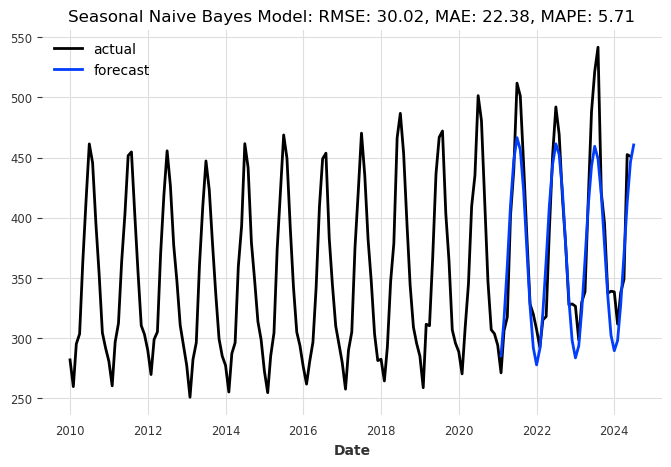

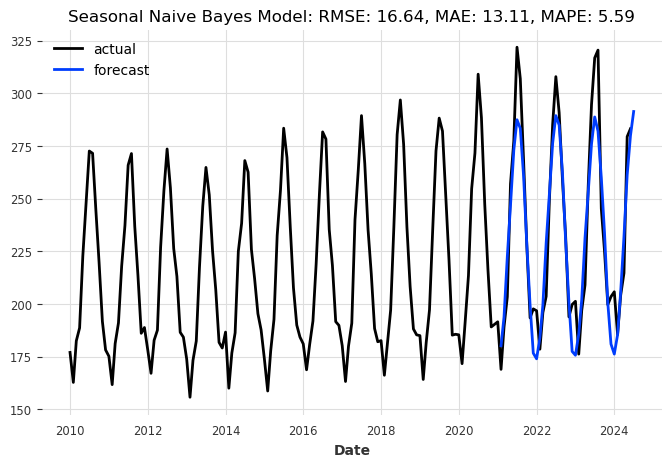

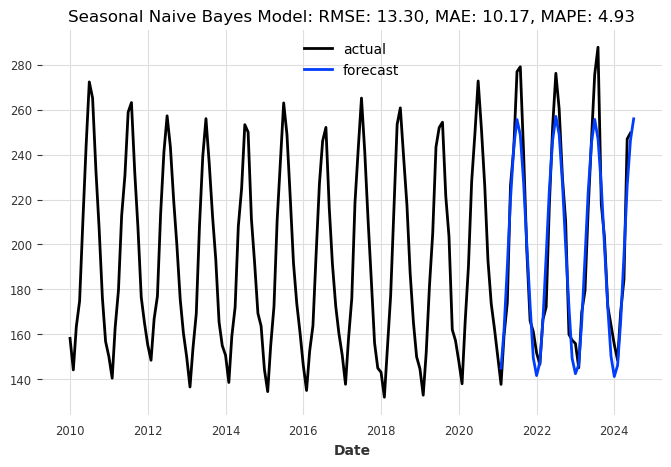

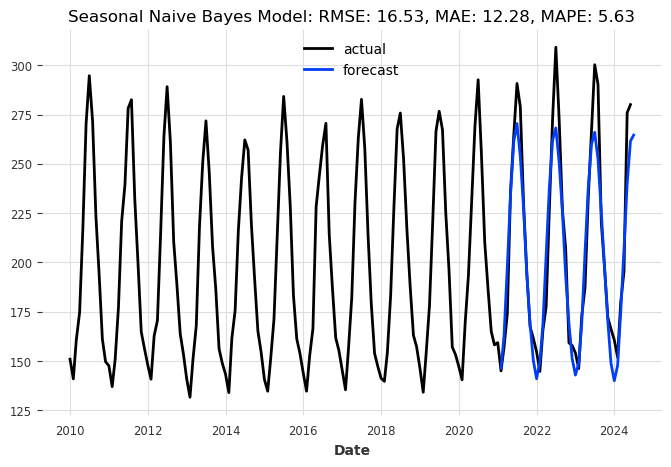

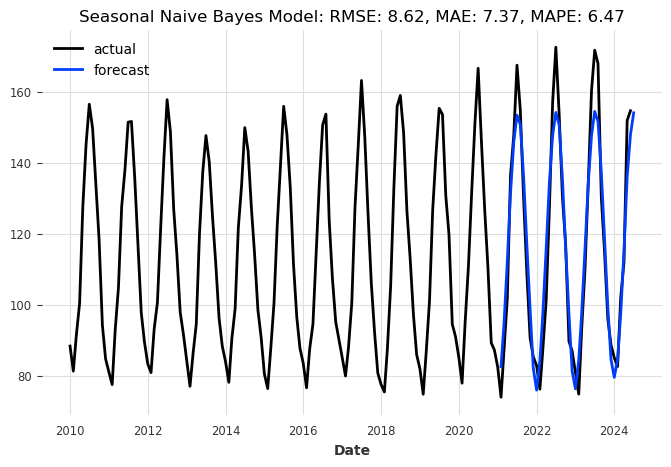

In [11]:
desc = 'Est. Total consumption (GWh)'

for i in range(len(timeseries_list)):
    print(file_list_name[i])
    zone = zone_names[i]
    
    # Find best paramater and for N linear model
    best_model = Nlinear_tuning(timeseries_list[i], desc, covar[zone], param_grid)
    best_param = best_model[1]

    # Train model with best parameter
    train, val = timeseries_list[i].split_after(pd.Timestamp('2021-01-01'))
    model = NLinearModel(input_chunk_length=best_param['input_chunk_length'], output_chunk_length=12, n_epochs=best_param['n_epochs'])
    model.fit(train[desc], past_covariates=train[covar[zone]], verbose=False, val_series=val[desc], val_past_covariates =val[covar[zone]])

    ypred = eval_model(model, timeseries_list[i], val[desc], desc, covar[zone])

    # Save metrics
    residential_metrics.loc[len(residential_metrics.index)] = [rmse(val[desc], ypred), 
                                                               mae(val[desc], ypred), 
                                                               mape(val[desc], ypred), 
                                                                zone_names[i],
                                                                best_model[0]]
    
    ypred.to_csv(f"./Predictions/Nlinear,{zone_names[i]},res.csv")


In [12]:
residential_metrics

,RMSE,MAE,MAPE,Zone,Model
0,30.019573,22.380146,5.708015,UNI,"NLinearModel(input_chunk_length=13, output_chu..."
1,16.637860,13.112164,5.587877,CNI,"NLinearModel(input_chunk_length=25, output_chu..."
2,13.302587,10.166944,4.929358,LNI,"NLinearModel(input_chunk_length=23, output_chu..."
3,16.526754,12.275902,5.631097,USI,"NLinearModel(input_chunk_length=23, output_chu..."
4,8.623322,7.367158,6.467445,LSI,"NLinearModel(input_chunk_length=25, output_chu..."


# Business data

In [13]:
business_metrics = pd.DataFrame(columns=['RMSE', 'MAE', 'MAPE', 'Zone', 'Model'])

In [14]:
covar = {
    'UNI': ['Export prices', 'Export values'],
    'CNI' : ['Export prices', 'Population', 'Import values'],
    'LNI' : ['Mean Air Temperature in Celsius'],
    'USI' : ['Mean Air Temperature in Celsius'],
    'LSI' : ['Mean Air Temperature in Celsius']
}



In [15]:
param_grid = {              # set up params for grid search
    'input_chunk_length': [i for i in range(12, 29)],
    'output_chunk_length': [i for i in range(12, 18)],
    'n_epochs': [225, 250],
    }

Electricity-ResBusClimateUNI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateCNI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateLNI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateUSI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateLSI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

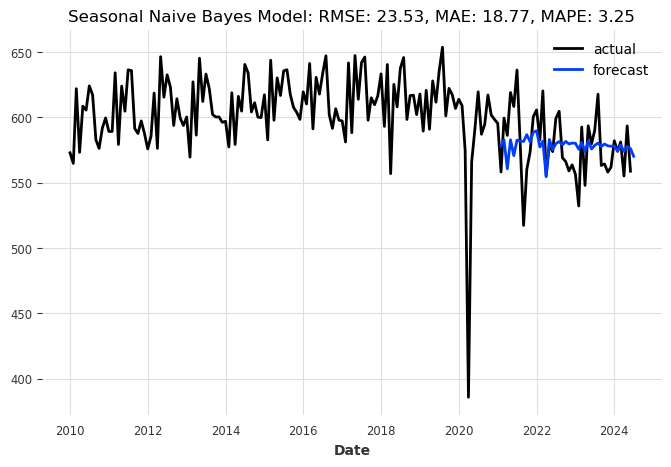

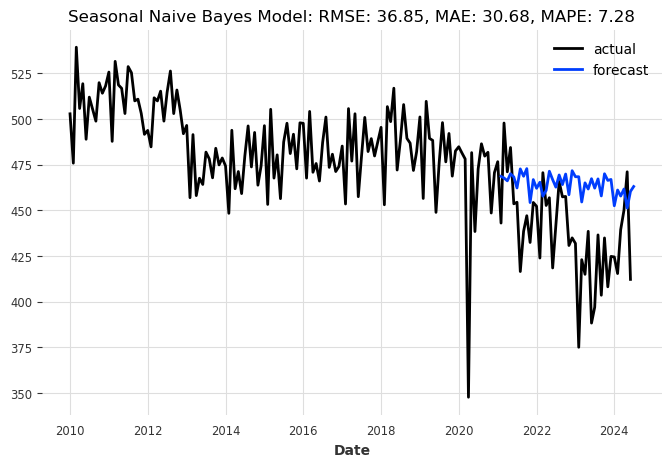

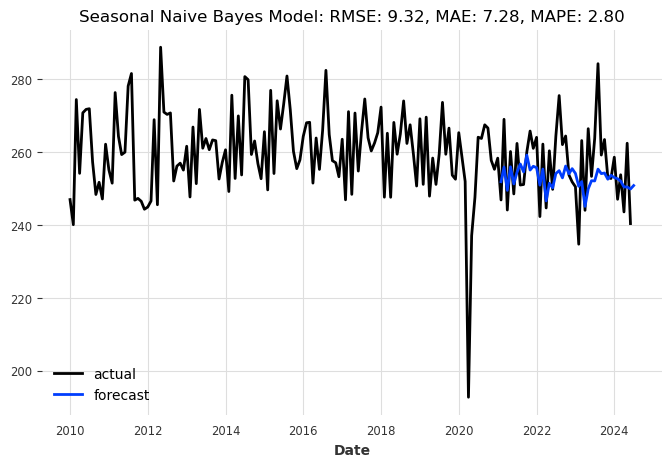

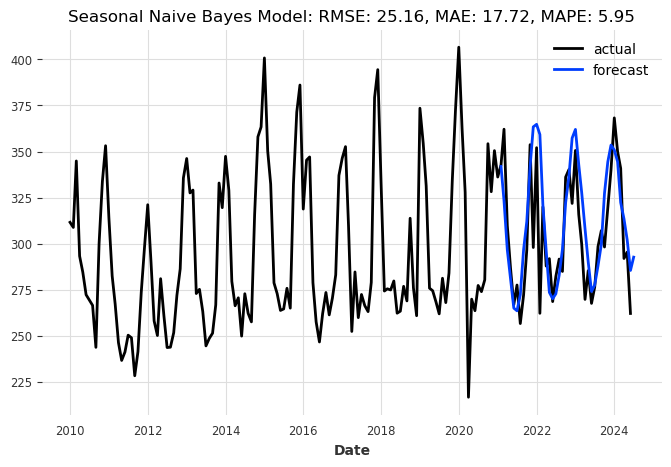

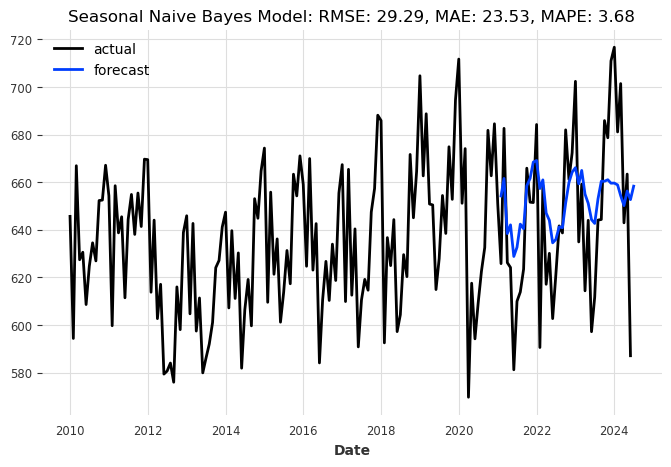

In [16]:
desc = 'Selected business demand (GWh)'

for i in range(len(timeseries_list)):
    print(file_list_name[i])
    zone = zone_names[i]

    # Find best paramater and for N linear model
    best_model = Nlinear_tuning(timeseries_list[i], past_covariates=None, DESC= desc, param_grid = param_grid)
    best_param = best_model[1]

    # Train model with best parameter
    train, val = timeseries_list[i].split_after(pd.Timestamp('2021-01-01'))
    model = NLinearModel(input_chunk_length=best_param['input_chunk_length'], output_chunk_length=best_param['output_chunk_length'], n_epochs=best_param['n_epochs'])
    model.fit(train[desc], verbose=False, val_series=val[desc])

    ypred = eval_model_no_cov(model, timeseries_list[i], val[desc], desc)

    # Save metrics
    business_metrics.loc[len(business_metrics.index)] = [rmse(val[desc], ypred), 
                                                               mae(val[desc], ypred), 
                                                               mape(val[desc], ypred), 
                                                                zone_names[i],
                                                                best_model[0]]
    
    ypred.to_csv(f"./Predictions/Nlinear,{zone_names[i]},bus.csv")


In [17]:
business_metrics

,RMSE,MAE,MAPE,Zone,Model
0,23.527528,18.771442,3.250912,UNI,"NLinearModel(input_chunk_length=13, output_chu..."
1,36.851001,30.676652,7.276363,CNI,"NLinearModel(input_chunk_length=21, output_chu..."
2,9.320569,7.275528,2.795333,LNI,"NLinearModel(input_chunk_length=24, output_chu..."
3,25.155597,17.715329,5.953199,USI,"NLinearModel(input_chunk_length=24, output_chu..."
4,29.288478,23.528358,3.684549,LSI,"NLinearModel(input_chunk_length=21, output_chu..."


# Business outlier adjusted

In [18]:
file_list_name = ['Electricity-ResBusClimateUNI.csv', 'Electricity-ResBusClimateCNI.csv', 
                  'Electricity-ResBusClimateLNI.csv', 'Electricity-ResBusClimateUSI.csv', 'Electricity-ResBusClimateLSI.csv']
path_name = '../AnalysisAndPreprocessing/ProcessedData_2020-04_Adjusted/'
timeseries_list = [get_timeseries(path_name + file) for file in file_list_name]
business_metrics_adjusted = pd.DataFrame(columns=['RMSE', 'MAE', 'MAPE', 'Zone'])

Electricity-ResBusClimateUNI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateCNI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateLNI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateUSI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Electricity-ResBusClimateLSI.csv


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

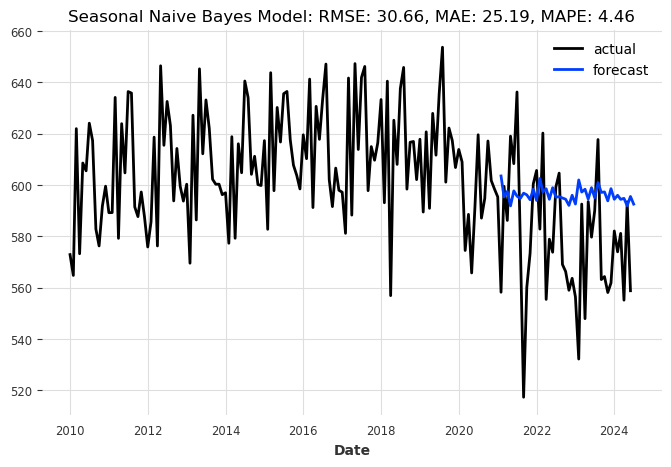

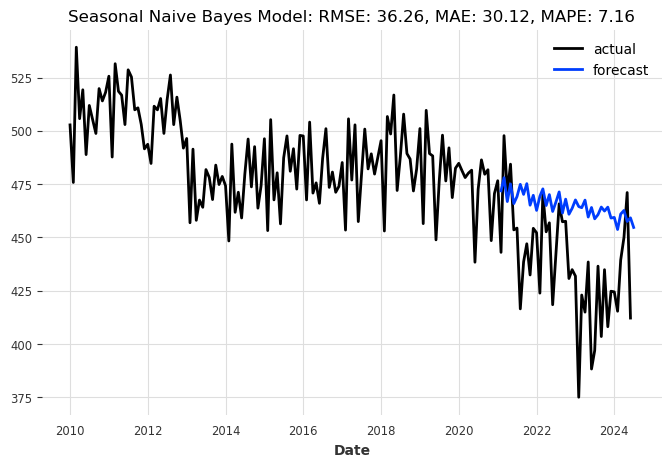

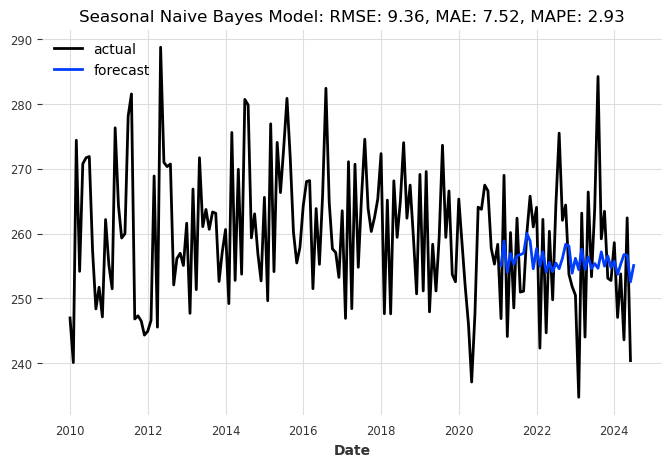

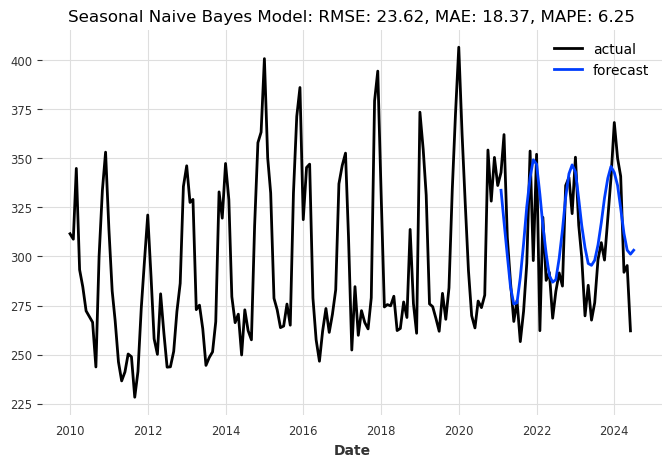

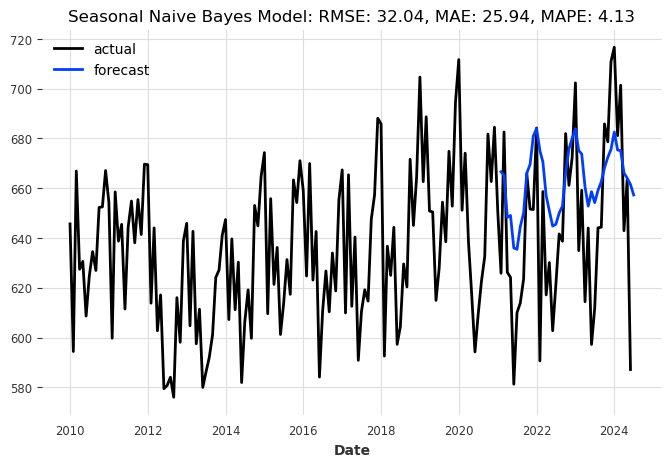

In [19]:
desc = 'Selected business demand (GWh)'

for i in range(len(timeseries_list)):
    print(file_list_name[i])
    zone = zone_names[i]

    # Find best paramater and for N linear model
    best_model = Nlinear_tuning(timeseries_list[i], past_covariates=None, DESC= desc, param_grid = param_grid)
    best_param = best_model[1]

    # Train model with best parameter
    train, val = timeseries_list[i].split_after(pd.Timestamp('2021-01-01'))
    model = NLinearModel(input_chunk_length=best_param['input_chunk_length'], output_chunk_length=best_param['output_chunk_length'], n_epochs=best_param['n_epochs'])
    model.fit(train[desc], verbose=False, val_series=val[desc])

    ypred = eval_model_no_cov(model, timeseries_list[i], val[desc], desc)

    # Save metrics
    business_metrics.loc[len(business_metrics.index)] = [rmse(val[desc], ypred), 
                                                               mae(val[desc], ypred), 
                                                               mape(val[desc], ypred), 
                                                                zone_names[i],
                                                                best_model[0]]
    
    ypred.to_csv(f"./Predictions/outlieradj/Nlinear,{zone_names[i]},bes.csv")


In [20]:
business_metrics

,RMSE,MAE,MAPE,Zone,Model
0,23.527528,18.771442,3.250912,UNI,"NLinearModel(input_chunk_length=13, output_chu..."
1,36.851001,30.676652,7.276363,CNI,"NLinearModel(input_chunk_length=21, output_chu..."
2,9.320569,7.275528,2.795333,LNI,"NLinearModel(input_chunk_length=24, output_chu..."
3,25.155597,17.715329,5.953199,USI,"NLinearModel(input_chunk_length=24, output_chu..."
4,29.288478,23.528358,3.684549,LSI,"NLinearModel(input_chunk_length=21, output_chu..."
5,30.656799,25.192623,4.457649,UNI,"NLinearModel(input_chunk_length=13, output_chu..."
6,36.259186,30.118338,7.157365,CNI,"NLinearModel(input_chunk_length=18, output_chu..."
7,9.355906,7.519700,2.928390,LNI,"NLinearModel(input_chunk_length=24, output_chu..."
8,23.621462,18.373005,6.246326,USI,"NLinearModel(input_chunk_length=12, output_chu..."
9,32.041458,25.942502,4.131515,LSI,"NLinearModel(input_chunk_length=27, output_chu..."
